
Gas Station Choice Modeling
---------------------------
This script analyzes gas station choice behavior using data from the 
Washington Metropolitan Area Regional Travel Survey. It builds a discrete choice model
to understand factors influencing which gas stations people choose.



c:\Users\asal97\Anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\asal97\AppData\Local\Temp\ipykernel_21624\4288341449.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you

Loading survey data...
Loading gas station data...
Loading geographic data...
Data loading complete.
Identifying gas station trips...
Number of gas station trips: 4112
Linking trips to final destinations...
Matching gas stations to TAZs...
Calculating TAZ centroids...
Creating route polygons...
Identifying stations along routes...
Adding distance and travel time data...
Calculating excess travel metrics...
Adding census and rural/urban classification data...
Mean excess travel time in the data is 52.134122548875276
Mean price in the data is 2.528730992281304
Mean excess travel time to chosen gas stations is 2.467517882689556
Mean price of chosen gas stations is 2.507287924892704
Adding demographic information...
Creating categorical variables...
Creating dummy variables...
Creating interaction terms...
['index', 'person_id', 'person_id_new', 'o_purpose', 'o_activity', 'o_tpb_taz', 'd_tpb_taz', 'travelers_total', 'vehicle_occupancy', 'hov_used', 'toll_road_used', 'distance', 'reported_t

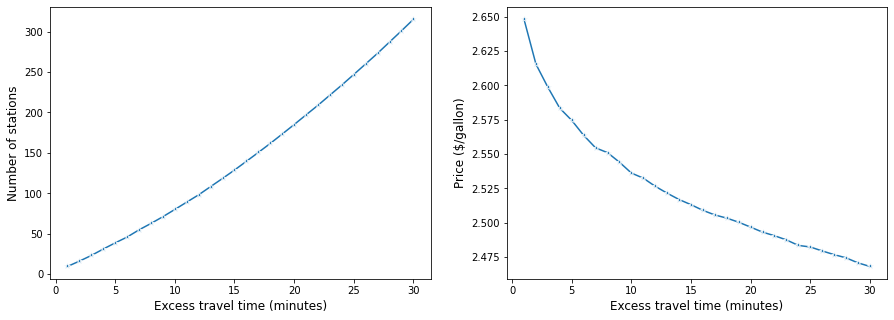

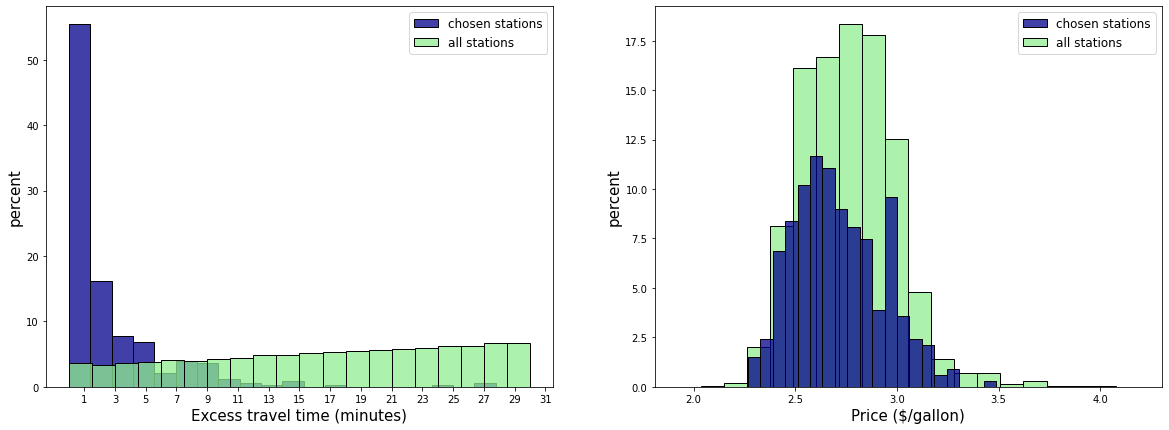

Analysis complete!


In [1]:

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
import pylogit as pl
from collections import OrderedDict
import datetime
import warnings
import os
import seaborn as sns
warnings.filterwarnings('ignore')


class GasStationChoiceModel:
    """
    A class to analyze gas station choice behavior and build discrete choice models.
    """
    
    def __init__(self, data_dir):
        """
        Initialize the model with data paths.
        
        Parameters:
        -----------
        data_dir : str
            Base directory for data files
        """
        self.data_dir = data_dir
        self.survey_dir = os.path.join(data_dir, "regional travel survey")
        self.gasoline_dir = os.path.join(data_dir, "gasoline price")
        self.rural_urban_dir = os.path.join(data_dir, "rural_urban")
        self.shapefiles_dir = os.path.join(data_dir, "a")
        self.produced_data_dir = os.path.join(data_dir, "produced data")
        # Initialize data containers
        self.trip = None
        self.trip_gas = None
        self.vehicle = None
        self.household = None
        self.person = None
        self.gasstation = None
        self.model_data = None
        self.model_final = None
        
    def load_data(self):
        """Load all required datasets"""
        print("Loading survey data...")
        self.trip = pd.read_csv(os.path.join(self.survey_dir, "trip.csv"))
        self.trip = self.trip.rename(columns=str.lower)
        
        self.vehicle = pd.read_csv(os.path.join(self.survey_dir, "vehicle.csv"))
        self.vehicle = self.vehicle.rename(columns=str.lower)
        
        self.household = pd.read_csv(os.path.join(self.survey_dir, "household.csv"))
        self.household = self.household.rename(columns=str.lower)
        
        self.person = pd.read_csv(os.path.join(self.survey_dir, "person.csv"))
        self.person = self.person.rename(columns=str.lower)
        
        print("Loading gas station data...")
        self.gasstation = pd.read_csv(os.path.join(self.gasoline_dir, "gasolinedata2018.csv"))
        self.gasstation.drop_duplicates(['stationid'], inplace=True)
        
        self.gasstation_full = pd.read_csv(os.path.join(self.gasoline_dir, "gasolinedata2018.csv"))
        self.gasstation1 = pd.read_csv(os.path.join(self.gasoline_dir, "Latest prices 2021-2022.csv"))
        self.gasstation1.drop_duplicates(['stationid'], inplace=True)
        # Merge gas brand information
        self.gasstation = self.gasstation.merge(
            self.gasstation1[['stationid', 'gasbrand']], 
            on='stationid', 
            how='left'
        )
        
        print("Loading geographic data...")
        # Census tract data
        self.census_tract24 = gpd.read_file(f"{self.shapefiles_dir}/tl_2017_24_tract.shp")
        self.census_tract51 = gpd.read_file(f"{self.shapefiles_dir}/tl_2017_51_tract.shp")
        self.census_tract11 = gpd.read_file(f"{self.shapefiles_dir}/tl_2017_11_tract.shp")
        self.census_tract54 = gpd.read_file(f"{self.shapefiles_dir}/tl_2017_54_tract.shp")
        
        self.census_tract = pd.concat([
            self.census_tract24, self.census_tract51, 
            self.census_tract11, self.census_tract54
        ])
        
        # Transportation Analysis Zones (TAZ) data
        self.taz = gpd.read_file(f"{self.shapefiles_dir}/Transportation_Analysis_Zones_(TAZ).shp")
        
        # Rural/urban classification
        self.rural_urban = pd.read_csv(f"{self.rural_urban_dir}/ruca2010revised.csv")
        
        print("Data loading complete.")
        
    def identify_gas_trips(self):
        """Identify trips to gas stations in the travel survey"""
        print("Identifying gas station trips...")
        # Filter trips to or from gas stations (activity code 8)
        self.trip_gas = self.trip.loc[
            ((self.trip['d_activity'] == 8) | (self.trip['o_activity'] == 8)) &
            (self.trip['d_activity'] != self.trip['o_activity'])
        ].reset_index(drop=True)
        
        print(f"Number of gas station trips: {len(self.trip_gas)}")
        # Extract origin gas station visits
        gas1 = self.trip_gas.loc[
            self.trip_gas['o_activity'] == 8,
            ['person_id', 'o_tract_fips', 'o_state_county_fips', 'o_tpb_taz', 'o_bmc_taz']
        ]
        gas1 = gas1.rename(columns={
            'o_tract_fips': 'tract',
            'o_state_county_fips': 'state_county',
            'o_tpb_taz': 'taz',
            'o_bmc_taz': 'bmc_taz'
        })
        
        # Extract destination gas station visits
        gas2 = self.trip_gas.loc[
            self.trip_gas['d_activity'] == 8,
            ['person_id', 'd_tract_fips', 'd_state_county_fips', 'd_tpb_taz', 'd_bmc_taz']
        ]
        gas2 = gas2.rename(columns={
            'd_tract_fips': 'tract',
            'd_state_county_fips': 'state_county',
            'd_tpb_taz': 'taz',
            'd_bmc_taz': 'bmc_taz'
        })
        
        # Combine origin and destination data, keeping unique TAZ values
        self.gas = pd.concat([gas1, gas2]).drop_duplicates(['taz']).reset_index(drop=True)
        
       
    
    def link_trip_destinations(self):
        """Link gas station trips with their final destinations"""
        print("Linking trips to final destinations...")
        # For each gas station visit, identify the subsequent destination
        for j in range(self.trip_gas.shape[0] - 1):
            if ((self.trip_gas.loc[self.trip_gas.index[j], 'person_id'] == 
                 self.trip_gas.loc[self.trip_gas.index[j+1], 'person_id']) &
                (self.trip_gas.loc[self.trip_gas.index[j+1], 'o_activity'] == 8) & 
                (self.trip_gas.loc[self.trip_gas.index[j], 'd_activity'] == 8)):
                
                # Record the final destination details
                self.trip_gas.loc[self.trip_gas.index[j], 'final_activity'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'd_activity']
                self.trip_gas.loc[self.trip_gas.index[j], 'final_taz'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'd_tpb_taz']
                self.trip_gas.loc[self.trip_gas.index[j], 'final_taz_bmc'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'd_bmc_taz']
                self.trip_gas.loc[self.trip_gas.index[j], 'final_tract'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'd_tract_fips']
                self.trip_gas.loc[self.trip_gas.index[j], 'final_state_county'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'd_state_county_fips']
                self.trip_gas.loc[self.trip_gas.index[j], 'travel_time_2_des'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'reported_travel_time']
                self.trip_gas.loc[self.trip_gas.index[j], 'distance_2_des'] = self.trip_gas.loc[self.trip_gas.index[j+1], 'distance']
        
        # Remove trips without final destination data
        self.trip_gas = self.trip_gas.dropna(subset=['final_activity', 'final_taz']).reset_index(drop=True)
        # Handle duplicate person IDs by creating unique identifiers

        self.trip_gas['person_id_new'] = self.trip_gas['person_id']
        duplicate_mask = self.trip_gas.duplicated(subset='person_id', keep=False)
        new_person_id = 1000  # Base for new IDs
        
        # Assign new IDs to duplicate entries
        unique_person_ids = self.trip_gas['person_id'].unique()
        for person_id in unique_person_ids:
            indices = self.trip_gas[(self.trip_gas['person_id'] == person_id) & duplicate_mask].index
            if len(indices) > 1:
                self.trip_gas.loc[indices[1], 'person_id'] = new_person_id
                new_person_id += 1
    
    def match_gas_stations_to_taz(self):
        """Identify gas stations in each Transportation Analysis Zone (TAZ)"""
        print("Matching gas stations to TAZs...")
        # Match TAZ with gas station locations
        taz1 = self.taz.to_crs("EPSG:32634")
        
        # Create a GeoDataFrame for gas stations
        station_gdp = gpd.GeoDataFrame(
            self.gasstation,
            geometry=gpd.points_from_xy(self.gasstation.longitude, self.gasstation.latitude),
            crs='epsg:4326'
        )
        station_gdp = station_gdp.to_crs("EPSG:32634")
        
        # Spatial join to find gas stations in each TAZ
        self.intersection1 = gpd.sjoin(taz1, station_gdp)
        self.intersection1 = self.gas.merge(self.gasstation, on='taz')
        self.intersection1 = self.intersection1.rename(columns={'retailaverage': 'price'})
        
        # Identify TAZs with single gas stations
        taz_station_counts = self.intersection1[['taz']].value_counts().reset_index()
        #taz_station_counts = taz_station_counts.rename(columns={0: 'count'})
        single_station_tazs = taz_station_counts.loc[taz_station_counts['count'] < 2]
        
        # Get station information for TAZs with single stations
        self.intersection2 = single_station_tazs.merge(self.intersection1, on='taz')
        self.intersection2 = self.intersection2[[
            'taz', 'stationid', 'name', 'latitude', 'longitude', 'gasbrand', 'price'
        ]]

        # Match trip data with single-station TAZs
        self.trip_gas_w_coordinate = self.trip_gas.merge(
            self.intersection2, 
            left_on='d_tpb_taz', 
            right_on='taz'
        )
    
    def calculate_taz_centroids(self):
        """Calculate centroids for each TAZ for spatial analysis"""
        print("Calculating TAZ centroids...")
        # Convert TAZ to geographic coordinate system
        self.taz = self.taz.to_crs('EPSG:4326')
        
        # Calculate centroid coordinates
        self.taz['centroid'] = self.taz['geometry'].centroid
        self.taz['centroid_x'] = self.taz['centroid'].x
        self.taz['centroid_y'] = self.taz['centroid'].y
        
        # Extract coordinates
        taz_coord = self.taz[['TAZ', 'centroid_x', 'centroid_y']]
        
        # Add origin TAZ coordinates
        trip_data_with_coords = self.trip_gas_w_coordinate.merge(
            taz_coord, 
            left_on='o_tpb_taz', 
            right_on='TAZ'
        )
        
        # Add final destination TAZ coordinates
        self.trip_gas_w_coordinate_final = trip_data_with_coords.merge(
            taz_coord, 
            left_on='final_taz', 
            right_on='TAZ'
        )
        
        # Mark as chosen stations
        self.trip_gas_w_coordinate_final['choice2'] = 1



    
    def create_route_polygons(self):
        """Create polygons representing potential travel routes"""
        print("Creating route polygons...")
        # Create rectangles around origin-destination pairs
        for index, row in self.trip_gas_w_coordinate_final.iterrows():
            min_lat = min(row.centroid_y_x, row.centroid_y_y)
            max_lat = max(row.centroid_y_x, row.centroid_y_y)
            min_lon = min(row.centroid_x_x, row.centroid_x_y)
            max_lon = max(row.centroid_x_x, row.centroid_x_y)
            
            self.trip_gas_w_coordinate_final.at[index, 'geometry'] = Polygon([
                (min_lon, min_lat), (max_lon, min_lat), 
                (max_lon, max_lat), (min_lon, max_lat)
            ])
        
        # Expand small rectangles to account for reasonable detours
        for i in range(self.trip_gas_w_coordinate_final.shape[0]):
            if self.trip_gas_w_coordinate_final.loc[i, 'geometry'].area >= 5:
                self.trip_gas_w_coordinate_final.loc[i, 'geometry1'] = self.trip_gas_w_coordinate_final.loc[i, 'geometry']
            else:
                self.trip_gas_w_coordinate_final.loc[i, 'geometry1'] = self.trip_gas_w_coordinate_final.loc[i, 'geometry'].buffer(5)
    
    def identify_stations_along_routes(self):
        """Find gas stations along potential travel routes"""
        print("Identifying stations along routes...")
        # Create GeoDataFrame from trip data
        trips_gdf = gpd.GeoDataFrame(
            self.trip_gas_w_coordinate_final,
            geometry=self.trip_gas_w_coordinate_final['geometry1'],
            crs='epsg:4326'
        )
        trips_gdf = trips_gdf.to_crs("EPSG:32634")
        
        # Create GeoDataFrame from gas stations
        station_gdp = gpd.GeoDataFrame(
            self.gasstation,
            geometry=gpd.points_from_xy(self.gasstation.longitude, self.gasstation.latitude),
            crs='epsg:4326'
        )
        station_gdp = station_gdp.to_crs("EPSG:32634")
        
        # Spatial join to find stations along routes
        intersection4 = gpd.sjoin(trips_gdf, station_gdp)
        
        # Prepare model data
        self.model_data = intersection4[[
            'person_id', 'person_id_new', 'o_purpose', 'o_activity', 'o_tpb_taz',
            'd_tpb_taz', 'travelers_total', 'vehicle_occupancy', 'hov_used',
            'toll_road_used', 'distance', 'reported_travel_time', 'final_taz',
            'final_activity', 'travel_time_2_des', 'distance_2_des', 'stationid_left',
            'stationid_right', 'travel_mode', 'mode_hh_vehicle', 'choice2'
        ]].reset_index()
        
        # Mark actually chosen stations
        self.model_data.loc[self.model_data['stationid_left'] == self.model_data['stationid_right'], 'choice'] = 1
        
        # Clean up and prepare
        self.model_data = self.model_data.rename(columns={'stationid_right': 'stationid'})
        self.model_data = self.model_data.drop_duplicates(
            subset=['person_id', 'stationid', 'o_tpb_taz', 'final_taz', 'd_tpb_taz', 'choice2']
        )
        self.model_data = self.model_data.sort_index()
  
    

    def add_distance_data(self):
        """Add distance and travel time data to stations"""
        print("Adding distance and travel time data...")
        # Load distance data from origin to gas stations
        distance_2_gas = pd.read_csv(f"{self.produced_data_dir}/distance_dijkstra_2_all_gas_2018.csv")
        distance_2_gas = distance_2_gas.merge(
            self.gasstation[['stationid', 'gasbrand']], 
            on='stationid', 
            how='left'
        )
        distance_2_gas = distance_2_gas.rename(columns={'retailaverage': 'price'})
        
        # Reshape the distance data
        data = pd.DataFrame()
        for i in range(0, 657):
            data1 = distance_2_gas[[
                'stationid', 'address', 'city', 'state', 'latitude', 'longitude',
                'gasbrand', 'price', f'distance{i}', f'source{i}', f'time{i}'
            ]]
            
            data1 = data1.rename(columns={
                f'distance{i}': 'distance_2_gas',
                f'source{i}': 'origin_taz',
                f'time{i}': 'time_2_gas'
            })
            
            data = pd.concat([data, data1])
        
        # Merge with model data
        self.model_data = self.model_data.merge(
            data, 
            left_on=['o_tpb_taz', 'stationid'], 
            right_on=['origin_taz', 'stationid']
        )
        
        # Load distance data from gas stations to destinations
        distance_fr_gas = pd.read_csv(f"{self.produced_data_dir}/distance_dijkstra_fr_all_gas_2018.csv")
        
        # Reshape the distance data
        data2 = pd.DataFrame()
        for i in range(0, 1166):
            data3 = distance_fr_gas[['final_taz', f'distance{i}', f'source{i}', f'time{i}']]
            
            data3 = data3.rename(columns={
                f'distance{i}': 'distance_fr_gas',
                f'source{i}': 'stationid',
                f'time{i}': 'time_fr_gas'
            })
            
            data2 = pd.concat([data2, data3])
        
        # Merge with model data
        self.model_data = self.model_data.merge(
            data2, 
            on=['final_taz', 'stationid']
        )
        
        # Load direct distance data from origin to destination
        distance_2_des = pd.read_csv(f"{self.produced_data_dir}/distance_dijkstra_fr_O_2_D_2018.csv")
        
        # Reshape the direct distance data
        data3 = pd.DataFrame()
        for i in range(0, 657):
            data4 = distance_2_des[['final_taz', f'distance{i}', f'source{i}', f'time{i}']]
            
            data4 = data4.rename(columns={
                f'distance{i}': 'distance_2_dest',
                f'source{i}': 'origin_taz',
                f'time{i}': 'time_2_des'
            })
            
            data3 = pd.concat([data3, data4])
        
        # Merge with model data
        self.model_data = self.model_data.merge(
            data3, 
            on=['origin_taz', 'final_taz']
        )
        
        # Fix column naming
        self.model_data = self.model_data.rename(columns={
            'time_2_gas_x': 'time_2_gas', 
            'time_2_gas_y': 'time_2_des'
        })
    
    def calculate_excess_travel(self):
        """Calculate excess travel time and distance for gas station detours"""
        print("Calculating excess travel metrics...")
        # Prepare final model data
        self.model_final = self.model_data
        # Calculate excess travel time (minutes)
        self.model_final['excess_traveltime'] = (
            self.model_final['time_2_gas'] + 
            self.model_final['time_fr_gas'] - 
            self.model_final['time_2_des']
        ) / 60
        
        # Calculate excess distance (miles)
        self.model_final['excess_dis'] = (
            self.model_final['distance_2_gas'] + 
            self.model_final['distance_fr_gas'] - 
            self.model_final['distance_2_dest']
        ) * 0.000621371  # Convert to miles
        
        # Set negative values to zero (no excess distance/time)
        self.model_final.loc[self.model_final['excess_dis'] < 0, 'excess_dis'] = 0
        self.model_final.loc[self.model_final['excess_traveltime'] < 0, 'excess_traveltime'] = 0
        
        # Extract gas station data
        self.model_gas = self.model_final[['stationid', 'latitude', 'longitude']].drop_duplicates(['stationid'])
    
    def add_census_data(self):
        """Add census tract and rural/urban classification data"""
        print("Adding census and rural/urban classification data...")
        # Convert census tract to appropriate projection
        taz1 = self.census_tract.to_crs("EPSG:32634")
        
        # Create GeoDataFrame for gas stations
        station_gdp = gpd.GeoDataFrame(
            self.model_gas,
            geometry=gpd.points_from_xy(self.model_gas.longitude, self.model_gas.latitude),
            crs='epsg:4326'
        )
        station_gdp = station_gdp.to_crs("EPSG:32634")
        
        # Spatial join to find gas stations in each census tract
        intersection1 = gpd.sjoin(taz1, station_gdp)
        
        # Extract relevant columns
        gas_census = intersection1[[
            'STATEFP', 'COUNTYFP', 'TRACTCE', 
            'stationid', 'latitude', 'longitude'
        ]]
        
        # Format census tract identifiers
        m = gas_census['TRACTCE'].astype('str').str.len().max()
        n = gas_census['COUNTYFP'].astype('str').str.len().max()
        gas_census['TRACTCE'] = gas_census['TRACTCE'].astype('str').str.rjust(m, '0')
        gas_census['COUNTYFP'] = gas_census['COUNTYFP'].astype('str').str.rjust(n, '0')
        
        # Create FIPS code
        gas_census['gas_State-County-Tract FIPS Code'] = (
            gas_census.STATEFP.astype('str') + 
            gas_census.COUNTYFP.astype('str') + 
            gas_census.TRACTCE.astype('str')
        )
        
        # Prepare rural/urban codes
        self.rural_urban['State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)'] = \
            self.rural_urban['State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)'].astype('str')
        
        # Merge with rural/urban classification
        gas_census = gas_census.merge(
            self.rural_urban, 
            left_on='gas_State-County-Tract FIPS Code', 
            right_on='State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)',
            how='left'
        )
        
        # Add rural/urban classification to model data
        self.model_final = self.model_final.merge(gas_census, on='stationid')
        
        # Print summary statistics
        print("Mean excess travel time in the data is", self.model_final.excess_traveltime.mean())
        print("Mean price in the data is", self.model_final.price.mean())
        print("Mean excess travel time to chosen gas stations is", 
              self.model_final.loc[self.model_final['choice'] == 1, 'excess_traveltime'].mean())
        print("Mean price of chosen gas stations is", 
              self.model_final.loc[self.model_final['choice'] == 1, 'price'].mean())
    
    def add_demographics(self):
        """Add demographic information"""
        print("Adding demographic information...")
        # Merge with person data
        self.model_final = self.model_final.merge(
            self.person, 
            left_on='person_id_new', 
            right_on='person_id'
        )
        
        # Handle missing demographic information
        self.model_final.loc[(self.model_final['travel_mode'] != 4), 'gender'] = -99
        self.model_final.loc[(self.model_final['travel_mode'] != 4), 'age_group'] = -99
        
        # Aggregate age groups
        self.model_final.loc[(self.model_final['age_group'] < 6) & (self.model_final['age_group'] > 0), 'age_agg'] = 'under18'
        self.model_final.loc[(self.model_final['age_group'] < 10) & (self.model_final['age_group'] >= 6), 'age_agg'] = 'above18-under65'
        self.model_final.loc[(self.model_final['age_group'] >= 10), 'age_agg'] = 'above65'
        
        # Merge with household data
        self.model_final = self.model_final.merge(self.household, on='household_id')
        
        # Merge with vehicle data
        self.model_final = self.model_final.merge(
            self.vehicle[['household_id', 'vehnum', 'bodytype']], 
            right_on=['household_id', 'vehnum'], 
            left_on=['household_id', 'mode_hh_vehicle'], 
            how='left'
        )
        
        # Categorize vehicle types
        self.model_final.loc[self.model_final['bodytype'] == 3, 'bodytype_new'] = 'SUV'
        self.model_final.loc[self.model_final['bodytype'] == 4, 'bodytype_new'] = 'truck'
        self.model_final.loc[self.model_final['bodytype_new'].isna(), 'bodytype_new'] = 'other_veh'
    
    def create_categorical_variables(self):
        """Create categorical variables and dummies for the model"""
        print("Creating categorical variables...")
        # Categorize destination activities
        activity_mapping = {
            'entertainment': [11, 12, 13, 14],
            'meal': [6, 7],
            'errand': [9, 10],
            'home': [1],
            'work': [2],
            'volunteer': [3],
            'school': [4],
            'shopping': [5],
            'Dropoff/pickup': [16],
            'other': [18]
        }
        
        for category, codes in activity_mapping.items():
            self.model_final.loc[self.model_final['final_activity'].isin(codes), 'activity_agg'] = category
        
        # Create trip purpose categories based on origin and destination
        # HBH = Home-based home, HBW = Home-based work, etc.
        self.model_final.loc[(self.model_final['o_activity'] == 1) & (self.model_final['final_activity'] == 1), 'trip_purpose'] = 'HBH'
        self.model_final.loc[(self.model_final['o_activity'] == 1) & (self.model_final['final_activity'] == 2), 'trip_purpose'] = 'HBW'
        self.model_final.loc[(self.model_final['o_activity'] == 2) & (self.model_final['final_activity'] == 1), 'trip_purpose'] = 'WBH'
        self.model_final.loc[(self.model_final['o_activity'] == 2) & (self.model_final['final_activity'] == 2), 'trip_purpose'] = 'WBW'
        self.model_final.loc[(self.model_final['o_activity'] == 1) & (self.model_final['final_activity'] != 1) & 
                           (self.model_final['final_activity'] != 2), 'trip_purpose'] = 'HBO'
        self.model_final.loc[(self.model_final['o_activity'] == 2) & (self.model_final['final_activity'] != 1) & 
                           (self.model_final['final_activity'] != 2), 'trip_purpose'] = 'WBO'
        self.model_final.loc[(self.model_final['o_activity'] != 1) & (self.model_final['o_activity'] != 2) & 
                           (self.model_final['final_activity'] == 1), 'trip_purpose'] = 'OBH'
        self.model_final.loc[(self.model_final['o_activity'] != 1) & (self.model_final['o_activity'] != 2) & 
                           (self.model_final['final_activity'] == 2), 'trip_purpose'] = 'OBW'
        self.model_final.loc[(self.model_final['o_activity'] != 1) & (self.model_final['o_activity'] != 2) & 
                           (self.model_final['final_activity'] != 2) & (self.model_final['final_activity'] != 1), 'trip_purpose'] = 'OBO'
        
        # Recode rural/urban variable (RUCA)
        self.model_final.loc[self.model_final['Primary RUCA Code 2010'] != 1, 'Primary RUCA Code 2010'] = 0
        
        # Rename person_id column
        self.model_final = self.model_final.rename(columns={'person_id_x': 'person_id'})
    
    def create_dummy_variables(self):
        """Create dummy variables for categorical features"""
        print("Creating dummy variables...")
        # Create age group dummies
        age_dummies = pd.get_dummies(self.model_final['age_agg']).astype('int')
        self.model_final = pd.concat([self.model_final, age_dummies], axis=1)
        
        # Recode gender
        self.model_final.loc[self.model_final['gender'] == 2, 'gender'] = 0
        self.model_final.loc[self.model_final['gender'] == -99, 'gender'] = 0
        
        # Create income dummies
        self.model_final['income_broad'] = self.model_final['hh_income_broad']
        self.model_final.loc[self.model_final['hh_income_broad'] == 2, 'income_broad'] = 0
        
        # Recode income categories
        income_mapping = {
            1: 'Less than $10,000',
            2: '$10,000-$14,999',
            3: '$15,000-$24,999',
            4: '$25,000-$34,999',
            5: '$35,000-$49,999',
            6: '$50,000-$74,999',
            7: '$75,000-$99,999',
            8: '$100,000-$149,999',
            9: '$150,000-$199,999',
            10: '$200,000 or more'
        }
        
        for code, label in income_mapping.items():
            self.model_final.loc[self.model_final['hh_income_detailed'] == code, 'hh_income_detailed'] = label
            
        income_dummies = pd.get_dummies(self.model_final['hh_income_detailed']).astype('int')
        self.model_final = pd.concat([self.model_final, income_dummies], axis=1)
        
        # Create gas brand dummies
        gasbrand_dummies = pd.get_dummies(self.model_final['gasbrand']).astype('int')
        self.model_final = pd.concat([self.model_final, gasbrand_dummies], axis=1)
        
        # Create activity dummies
        activity_dummies_agg = pd.get_dummies(self.model_final['activity_agg']).astype('int')
        self.model_final = pd.concat([self.model_final, activity_dummies_agg], axis=1)
        
        # Create trip purpose dummies
        purpose_dummies = pd.get_dummies(self.model_final['trip_purpose']).astype('int')
        self.model_final = pd.concat([self.model_final, purpose_dummies], axis=1)
        
        # Create vehicle type dummies
        veh_dummies = pd.get_dummies(self.model_final['bodytype_new']).astype('int')
        self.model_final = pd.concat([self.model_final, veh_dummies], axis=1)
        
        return age_dummies, income_dummies, purpose_dummies, veh_dummies
    
    def create_interaction_terms(self, age_dummies, income_dummies, purpose_dummies, veh_dummies):
        """Create interaction terms with travel time"""
        print("Creating interaction terms...")
        # Create rural/urban-time interaction
        self.model_final['gas_core_community_time_interaction'] = (
            self.model_final['Primary RUCA Code 2010'] * 
            self.model_final['excess_traveltime']
        )
        
        # Add intercept term
        self.model_final['intercept'] = 1
        
        # Create purpose-time interactions
        for purpose_group in purpose_dummies.columns:
            self.model_final[f'{purpose_group}_time_interaction'] = (
                self.model_final[purpose_group] * 
                self.model_final['excess_traveltime']
            )
        print(list(self.model_final.columns))
        
        # Create age-time interactions
        for age_group in age_dummies.columns:
            self.model_final[f'{age_group}_time_interaction'] = (
                self.model_final[age_group] * 
                self.model_final['excess_traveltime']
            )
        
        # Create gender-time interaction
        self.model_final['female_time_interaction'] = (
            self.model_final['gender'] * 
            self.model_final['excess_traveltime']
        )
        
        # Create income-time interactions
        for income_group in income_dummies.columns:
            self.model_final[f'{income_group}_time_interaction'] = (
                self.model_final[income_group] * 
                self.model_final['excess_traveltime']
            )
        
        # Create low income-time interaction
        self.model_final['low_income_time_interaction'] = (
            self.model_final['income_broad'] * 
            self.model_final['excess_traveltime']
        )
        
        # Create vehicle type-time interactions
        for veh_group in veh_dummies.columns:
            self.model_final[f'{veh_group}_time_interaction'] = (
                self.model_final[veh_group] * 
                self.model_final['excess_traveltime']
            )
    
    def process_time_of_day(self):
        """Process time-of-day information and prepare peak/off-peak indicators"""
        print("Processing time of day information...")
        # Get trip data with time information
        
        
        self.gasstation_full['date']=pd.to_datetime(self.gasstation_full['startdate'])
        self.gasstation_full['month-date']=self.gasstation_full['date']
        a=self.gasstation_full[['stationid', 'date','retailaverage']].merge(self.model_final[['stationid','tdate_string']],on='stationid')


        merged_df = a[((a['tdate_string'] <= a['date']) & (a['tdate_string'] >= (a['date'] - pd.DateOffset(weeks=1))))]
        merged_df=merged_df.drop_duplicates(['stationid','tdate_string'])
        match_dates=merged_df.merge(self.model_final, on=['stationid','tdate_string'])
        corr_match_dates=match_dates.loc[match_dates['choice']==1,'person_id'].value_counts().reset_index()
        corr_match_dates=corr_match_dates.merge(match_dates, on='person_id')
        self.model_final=corr_match_dates
        trip_data = self.trip_gas_w_coordinate_final
        trip_data = trip_data.drop_duplicates([
            'person_id', 'o_tpb_taz', 'final_taz', 
            'departure_time_hhmm', 'arrival_time_hhmm', 'd_tpb_taz'
        ])
        
        
        
        
        # Merge with model data
        self.model_final = trip_data[[
            'person_id', 'o_tpb_taz', 'final_taz', 
            'departure_time_hhmm', 'arrival_time_hhmm', 'd_tpb_taz'
        ]].merge(
            self.model_final, 
            on=['person_id', 'o_tpb_taz', 'final_taz', 'd_tpb_taz']
        )
        
        # Extract hour from departure and arrival times
        self.model_final['dep_hour'] = pd.to_datetime(
            self.model_final['departure_time_hhmm'], 
            format="%H:%M"
        ).dt.hour
        
        self.model_final['arr_hour'] = pd.to_datetime(
            self.model_final['arrival_time_hhmm'], 
            format="%H:%M"
        ).dt.hour
        
        # Filter out non-auto trips
        self.model_final = self.model_final.loc[self.model_final['travel_mode'] != 7]
        
        # Categorize peak/off-peak times
        self.model_final['peak'] = float('nan')
        self.model_final.loc[
            (self.model_final['dep_hour'] <= 18) & 
            (self.model_final['dep_hour'] >= 16), 'peak'
        ] = 'evening_peak'
        self.model_final.loc[self.model_final['peak'].isna(), 'peak'] = 'off_peak'
        
        # Extract date components
        self.model_final['day'] = pd.DatetimeIndex(self.model_final['tdate_string']).day
        self.model_final['month'] = pd.DatetimeIndex(self.model_final['tdate_string']).month
        self.model_final['year'] = pd.DatetimeIndex(self.model_final['tdate_string']).year
        self.model_final['weekday'] = pd.DatetimeIndex(self.model_final['tdate_string']).weekday
        
        # Create peak time dummies
        peak_dummies = pd.get_dummies(self.model_final.peak).astype('int')
        self.model_final = pd.concat([self.model_final, peak_dummies], axis=1)
        
        # Create peak time interactions
        for peak_group in peak_dummies.columns:
            self.model_final[f'{peak_group}_time_interaction'] = (
                self.model_final[peak_group] * 
                self.model_final['excess_traveltime']
            )
            
    
    def limit_travel_time(self, max_time=30):
        """Limit maximum excess travel time for analysis"""
        print(f"Limiting to trips with excess travel time < {max_time} minutes...")
        # Apply time limit
        model_subset = self.model_final.loc[self.model_final['excess_traveltime'] < max_time]

        # Keep only people who have a chosen alternative
        chosen_people = model_subset.loc[
            model_subset['choice'] == 1, 'person_id'
        ].value_counts().reset_index()
        
        model_subset = chosen_people.merge(model_subset, on='person_id')
        print(f"Remaining observations: {len(model_subset)}")
        
        # Ensure all choices are properly coded
        model_subset.loc[model_subset['choice'].isna(), 'choice'] = 0
        
        # Get average gas prices by station
        self.gasstation_full = pd.read_csv(f"{self.gasoline_dir}/gasolinedata2018.csv")
        station_avg_prices = self.gasstation_full.groupby(['stationid']).agg({'retailaverage': 'mean'}).reset_index()
        station_avg_prices = station_avg_prices.rename(columns={'retailaverage': 'price_new'})
        
        # Add to model data
        model_subset = station_avg_prices.merge(model_subset, on='stationid')
        # Calculate price difference from average
        model_subset['price_z'] = model_subset['retailaverage'] - model_subset['price_new']
        return model_subset
    
    def estimate_choice_model(self, model_data):
        """Estimate discrete choice model"""
        print("Estimating choice model...")
        # Define model specification
        specification = OrderedDict([
            ('retailaverage', 'all_same'),
            ('excess_traveltime', 'all_same'),
            ('Primary RUCA Code 2010', 'all_same'),
            
            # Trip purpose-time interactions
            ('OBO_time_interaction', 'all_same'),
            ('HBO_time_interaction', 'all_same'), 
            ('HBW_time_interaction', 'all_same'),
            ('OBH_time_interaction', 'all_same'),
            ('OBW_time_interaction', 'all_same'),
            ('WBH_time_interaction', 'all_same'),
            ('WBO_time_interaction', 'all_same'),
            ('WBW_time_interaction', 'all_same'),
            
            # Demographic-time interactions
            ('above65_time_interaction', 'all_same'),
            ('female_time_interaction', 'all_same'),
            ('low_income_time_interaction', 'all_same'),
            ('off_peak_time_interaction', 'all_same'),
            
            # Gas brand dummies
            ('Shell', 'all_same'),
            ('Exxon', 'all_same'),
            ('BP', 'all_same'),
            ('Sunoco', 'all_same'),
            ('Costco', 'all_same'), 
            ('Sheetz', 'all_same'),
            ('Wawa', 'all_same'),   
            ('7-Eleven', 'all_same'),  
            ("BJ's", 'all_same'),
            ("Safeway", 'all_same'),
            ("Valero", 'all_same'),
            ('Liberty', 'all_same')
        ])
        
        # Print descriptive statistics
        print("\nRetail average price statistics:")
        print(model_data['retailaverage'].describe())
        
        print("\nExcess travel time statistics:")
        print(model_data['excess_traveltime'].describe())
        
        print("\nMean retail average for non-chosen alternatives:")
        print(model_data.loc[model_data['choice'] == 0, 'retailaverage'].mean())
        
        # Prepare data for model estimation
        model_data = model_data.sort_values(by='person_id')
        
        # Create choice model
        model_spec = pl.create_choice_model(
            data=model_data,
            alt_id_col='stationid',
            obs_id_col='person_id',
            choice_col='choice',
            specification=specification,
            model_type='MNL'
        )
        
        # Estimate the model
        model_spec.fit_mle(np.zeros(27))
        print(model_spec.get_statsmodels_summary())
        
        # Calculate value of time (VOT)
        vot = model_spec.params['excess_traveltime'] * 60 / model_spec.params['retailaverage']
        print(f'Value of Time (VOT) = {vot}')
        
        # Generate predictions
        model_data['prediction'] = model_spec.predict(model_data, return_long_probs=True)
        
        return model_spec, model_data
    
    def visualize_results(self, model_data):
        """Visualize model results"""
        print("Generating visualizations...")
        f=pd.DataFrame()
        e=pd.DataFrame()
        for i in range(1,31):
            e['time_mean']=[model_data.loc[model_data['excess_traveltime']<i,'person_id'].value_counts().mean()]
            e['price']=[model_data.loc[model_data['excess_traveltime']<i].groupby(['person_id']).agg({'retailaverage':'min'})['retailaverage'].mean()]
            e['index']=i
            f=pd.concat([e,f])
        # Create figure for predictions vs excess travel time
        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
        sns.lineplot(x=f['index'],y=f['time_mean'],ax=ax1,marker='*')
        sns.lineplot(x=f['index'],y=f['price'],ax=ax2,marker='*')
        ax1.set_xlabel('Excess travel time (minutes)',fontsize='12')
        ax1.set_ylabel('Number of stations',fontsize='12')
        ax2.set_xlabel('Excess travel time (minutes)',fontsize='12')
        ax2.set_ylabel('Price ($/gallon)',fontsize='12')
        plt.show()
        
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=[20,7])
        n=model_data.loc[model_data['choice']==1].groupby(['person_id']).agg({'excess_traveltime':'mean'})
        m=model_data.loc[model_data['choice']==0].groupby(['person_id']).agg({'excess_traveltime':'mean'})

        a=model_data.loc[model_data['choice']==1].groupby(['person_id']).agg({'retailaverage':'mean'})
        b=model_data.loc[model_data['choice']==0].groupby(['person_id']).agg({'retailaverage':'mean'})

        a['choice']='chosen stations'
        b['choice']='other stations'
        n['choice']='chosen stations'
        m['choice']='other stations'
        d=pd.concat([n,m])
        c=pd.concat([a,b])


        sns.histplot(n,ax=ax1, x="excess_traveltime",bins=20,stat="percent",common_norm=False,kde=False,label='chosen stations', color='darkblue')
        sns.histplot(model_data,ax=ax1, x="excess_traveltime", bins=20,stat="percent",common_norm=False,kde=False,label='all stations',color='lightgreen')



        sns.histplot(model_data,ax=ax2, x="retailaverage", bins=20,stat="percent",common_norm=False,kde=False,label='all stations',color='lightgreen')
        sns.histplot(a,ax=ax2, x="retailaverage", bins=20,stat="percent",common_norm=False,kde=False,label='chosen stations', color='darkblue')
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles[::-1], labels=labels[::-1], loc='upper right', fontsize='12')
        ax1.legend(loc='upper right', fontsize='12')

        #ax2.legend(loc='upper right', fontsize='12')

        # g.set_xlim(1,31)
        # ax1.legend(title='', loc='upper right', labels=['other stations', 'chosen stations'],fontsize='15')

        # ax2.legend(title='', loc='upper left', labels=['other stations', 'chosen stations'],fontsize='15')

        ax1.set_xlabel('Excess travel time (minutes)',fontsize='15')
        ax2.set_xlabel('Price ($/gallon)',fontsize='15')
        ax1.set_ylabel('percent',fontsize='15')
        ax2.set_ylabel('percent',fontsize='15')
        ax1.set_xticks(range(1,32,2))

        plt.show()
   
    
    
    def run_analysis(self):
        """Run the full analysis pipeline"""
        self.load_data()
        self.identify_gas_trips()
        self.link_trip_destinations()
        self.match_gas_stations_to_taz()
        self.calculate_taz_centroids()
        self.create_route_polygons()
        self.identify_stations_along_routes()
        self.add_distance_data()
        self.calculate_excess_travel()
        self.add_census_data()
        self.add_demographics()
        self.create_categorical_variables()
        age_dummies, income_dummies, purpose_dummies, veh_dummies = self.create_dummy_variables()
        self.create_interaction_terms(age_dummies, income_dummies, purpose_dummies, veh_dummies)
        self.process_time_of_day()
        
        # Limit to reasonable travel times
        model_data = self.limit_travel_time(max_time=30)
        print(list(model_data.columns))
        
        # Estimate choice model
        model_spec, model_data = self.estimate_choice_model(model_data)
        
        # Visualize results
        self.visualize_results(model_data)
        
        return model_spec, model_data


if __name__ == "__main__":
    # Set data directory
    DATA_DIR = r'C:\Users\asal97\Desktop\PhD_Journey\PhD_Asal\EV\data'  # Update this to your actual path
    
    # Create and run the model
    model = GasStationChoiceModel(DATA_DIR)
    model_spec, final_data = model.run_analysis()
    
    print("Analysis complete!")